In [45]:
import math

In [68]:
# we will be coding a graph to viz the basic math functio9n sand ops

#we iwll define  aclass vals
class vals:
    #now we want to know what vals tougether geretated theres 100 in this case
    #we will maintain  a tuple to handel this
    def __init__(self,data,_children=(),_ops='',_label=''):

        self.data = data
        #we pass it into a set so that thge space is effciently utilized
        self._prev = set(_children)
        self._ops = _ops
        self._label = _label
        self.grad = 0.0
        #define backprop
        self._backprop = lambda: None

    def __repr__(self):
        #prints out the data
        return  f"the data is {self.data} "

    #adds 2 vals
    def __add__(self, other):

        #this is the wrapper for non class types ex: a+1 where a =>vals
        other = other if isinstance(other,vals) else vals(other)

        d =  vals(self.data + other.data, (self,other),'+')    
        #definiation of derivatives for addition
        def _backprop():
            # self.grad = 1.0 * d.grad #cause diffrentiation with self is a one
            # other.grad = 1.0 * d.grad
            #now we add the res back to the val so as to handel cases like a=b+b=2b so as to get 2 as derivative
            #these are the cases where self = other
            self.grad += 1.0 * d.grad #cause diffrentiation with self is a one
            other.grad += 1.0 * d.grad

        #this is like a way to overwrite the global var declaration through func calls
        d._backprop = _backprop
        return d

    #muls 2 vals
    def __mul__(self, other):
        
        other = other if isinstance(other,vals) else vals(other)
        d =  vals(self.data * other.data, (self,other),'*')          
        #definiation of derivatives for muls
        def _backprop():
            #this makes sense for a multipicative operation
            self.grad += d.grad * other.data
            other.grad += d.grad * self.data
        
        d._backprop = _backprop
        return d
    
    #to support ops like 6*a => 6.__mul__(a) => a.__mul__(6)
    def __rmul__(self, other):
        return self* other
    #similary 
    def __radd__(self, other):
        return self+other

    #here we define tanh although this can be atomically implemented using the "e" solely to keep the defination simple
    def tanh(self):
        #treat it as tanh(x)
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        #we return the params pof val class ie.. t would be data 'tanh' will be the ops and so on, so its more like calling the activation on self
        res = vals(t, (self,), 'tanh')
        def _backprop():
            #this makes sense for a tanh operation
            self.grad = (1- t**2)* res.grad  

        res._backprop = _backprop
        return res
    
    def expo(self):
        x = self.data
        res = vals(math.exp(x),(self,),'exp')

        def _backprop():
            # self.grad = res.grad * math.exp(x)
            self.grad = res.grad * res.data

        res._backprop = _backprop
        return res
    
    def __pow__(self, other):

        assert isinstance(other,(int,float)) ,"make sure that the power is real"
        res = vals(self.data ** other, (self,), f'**{other}')
        def _backprop():
            #diffrenetial of form x**(constant)
            self.grad = res.grad * other * (self.data ** (other-1))
        res._backprop = _backprop
        return res
    
    #we treat a/b = a*(b**-1)
    def __truediv__(self, other):
        return self*other**-1
    
    #for sub we can implement negation
    def __neg__(self):
        return self *-1
    def __sub__(self, other):
        return self + (-other)
    
    #now we will define the back prop function (read thsi function only after ' propogate backwards ')
    def backprop(self):
        #this employes a basic topological sort
        comp = []
        visited  = set()
        def recc(v):
            
            if v not in visited:  
                #add to visited
                visited.add(v)
                for node in v._prev:
                    # call back recc
                    recc(node)
                comp.append(v)
        recc(self)
        #init the grad at 1
        self.grad = 1.0
        for node in reversed(comp):
            node._backprop()   
    

a = vals(2.0, _label='a')
b = vals(-3.0, _label='b')
c = vals(10.0, _label='c')
e = a*b ;e._label = 'e'
d = e+c ;d._label = 'd'
f = vals(-2.0, _label='f')
L = d*f ;L._label = 'L'

THIS IS TO CALCULATE THE GRADIENTS: (only for the L func ..we will generalise this later)

In [417]:
def calculate_grad(node): #this depecits d(L1)/d(x)

    # x = node._label
    # #this is the samll val h wrtto which we cal gradient 
    # h = 0.0001 
    # #we wil def local vars
    # a1=a.data
    # b1=b.data
    # c1=c.data
    # d1=d.data
    # e1=e.data
    # f1=f.data

    # #we will cal the bump
    # if(x=='a'):
    #     a1 = a1 + h
    # if(x=='b'):
    #     b1 = b1 + h
    # if(x=='c'):
    #     c1 = c1 + h
    # if(x=='d'):
    #     d1 = d1 + h
    # if(x=='e'):
    #     e1 = e1 + h
    # if(x=='f'):
    #     f1 = f1 + h

    # L1 = L.data
    # #now we need to cal L2
    # e1 = a1*b1 
    # d1 = e1+c1 
    # L2 = d1*f1 

    # grad = (L2-L1)/h
    # return grad

    #well now we can make this code more efficient
    h = 1e-4
    #keeps labels and nodes together
    val = {'a':a , 'b':b , 'c':c , 'd':d, 'e':e , 'f':f , 'L':L}
    #this maps the smae keys with the data vals
    values = {k: v.data for k,v in val.items() }

    #this is bump
    if node._label == 'a' or 'b' or 'c' or 'f':
        values[node._label] += h
    #anything with  write should only be bumped after the write

    values['e'] = values['a']* values['b']
    if node._label == 'e':
        values[node._label] += h

    values['d'] = values['e'] + values['c']
    if node._label == 'd':
        values[node._label] += h

    if node._label == 'L':
        values[node._label] += h
        L2 = L.data + h
    else:
        L2 = values['d']* values['f']


    L1 = L.data
    return (L2-L1)/h

In [418]:
i =  calculate_grad(L)
print(i)

0.9999999999976694


GENERATE THE GRAPH USING GRAPVIZ:

In [36]:
# now we can code an expressioin graph out 
#we will use the graphviz lib
from graphviz import Digraph

#this will populate the nodes and edges set by usingDFS
def trace(root):

    nodes,edges = set(),set()
    #his reccursive function will do thetraversal
    def recc(v):

        if v not in nodes:
            #we add the ele not the visited set 
            nodes.add(v)
            for n in v._prev:
                #add the edges to the set
                edges.add((n,v))
                #call the recc function
                recc(n)

    recc(root)
    return nodes,edges



def create_graph(root):

    #this derfines the export format of the graph and also how irts aligned
    make = Digraph(format= 'svg', graph_attr= {'rankdir':'LR'})

    nodes,edges = trace(root)

    for n in nodes:

        # #we will caluculate the grads here
        # n_grad = calculate_grad(n)

        uid = str(id(n))
        # make.node(name= uid, label= "{%s | data= %.4f | gradient= %.4f}"% (n._label, n.data, n_grad ), shape= 'record' )
        make.node(name= uid, label= "{%s | data= %.4f | gradient= %.4f}"% (n._label, n.data, n.grad), shape= 'record' )

        if n._ops:
            #we will create a dummy node if its an op
            make.node(name= uid+n._ops, label= (n._ops))
            make.edge(uid+n._ops, uid)

    for n1, n2 in edges:

        make.edge(str(id(n1)), str(id(n2)) + n2._ops  )

    return make

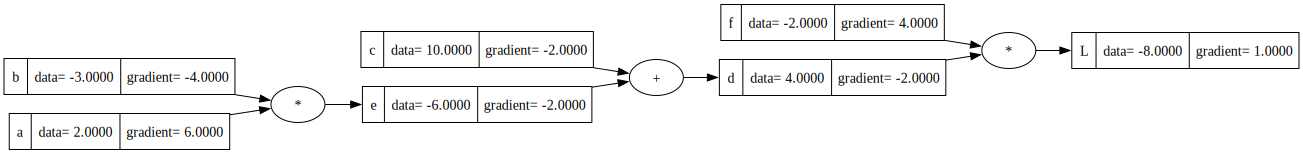

In [420]:
create_graph(L)

NOW WE WILL TRY'NA CREATE A NURAL NET

In [407]:
import numpy as np 
import matplotlib.pyplot as plt

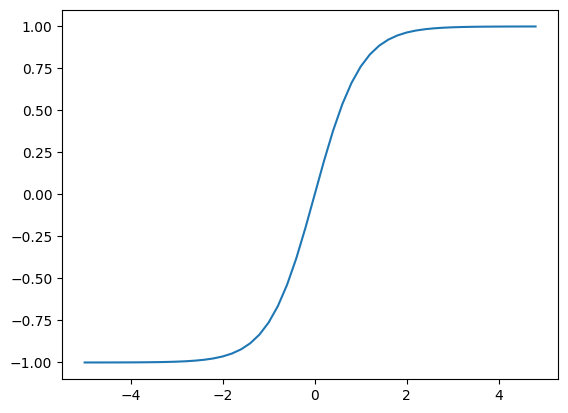

In [408]:
#this is  tanh activation function from numpy that we'll be using
arr = np.arange(-5,5,0.2)
plt.plot(arr, np.tanh(arr))

In [429]:
#now we will write a nural net by initalising weight biases and inputs from the class vals we created

#inputs x1, x2
x1 = vals(2.0, _label='x1')
x2 = vals(0.0, _label='x2')
#weights w1, w2
w1 = vals(-3.0, _label='w1')
w2 = vals(1.0, _label='w2')
#bias
b = vals(6.8813735870195432, _label='b')
#we take the dot product of the inputs agianst weights to get the vector
x1w1 = x1 * w1 ; x1w1._label = 'x1w1'
x2w2 = x2 * w2 ; x2w2._label = 'x2w2'
#this corresponds to [inputs]*[weights] ;we add these
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2._label = 'x1w1x2w2'
#we add the bias(b) to the vector
res = x1w1x2w2 + b ; res._label = 'n'
o = res.tanh() ; o._label = 'o'



In [426]:
# #for now we manually define the grads
# o.grad = 1.0
# #the local derivative of the tan function using 1- tanh()**2
# # print(1-(o.data)**2) ~0.5 so using this
# res.grad = 0.5
# #now coming to the addition treat it as d(tanh(&))/d(b) {& = x1w1x2w2 + b}
# #tanh'(&)*&' and this evals to 0.5(from prev res)*&' => &' = (x1w1x2w2 + b)' which evals to one in either case 
# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# #backpropiing similarly yilds us
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# #now that we finally have and * ops we get dependece
# x1.grad = 0.5*-3.0 #this is bec's 0.5*(x1w1)' = 0.5*(w1)
# w1.grad = 0.5*2.0 # 0.5*(x1)
# x2.grad = 0.5*1.0 #similarly
# w2.grad = 0.5*0.0


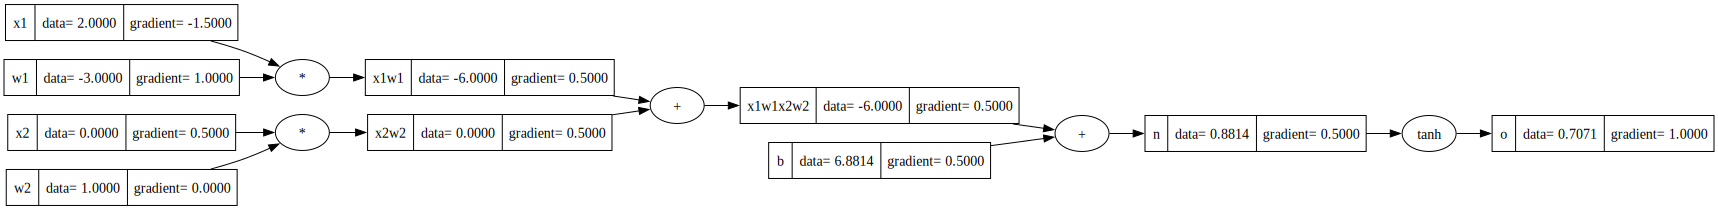

In [427]:
create_graph(o)

NOW THAT WE HAVE DEFINED THE GRADS ABOVE IN THE CLASS( propogate backwards )

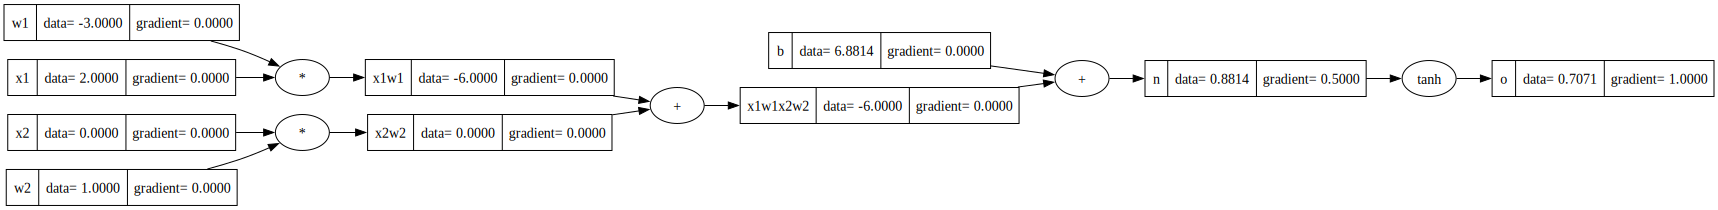

In [430]:
#for the base case we define the grad as 1
o.grad = 1.0
o._backprop()
#and similarly we can call the backprop for all these ndoes
#so the idea is     ------> '''''''       to propogate backward      ''''''''''
create_graph(o)#now we see the grad of'n' go from 0 to 0.5 


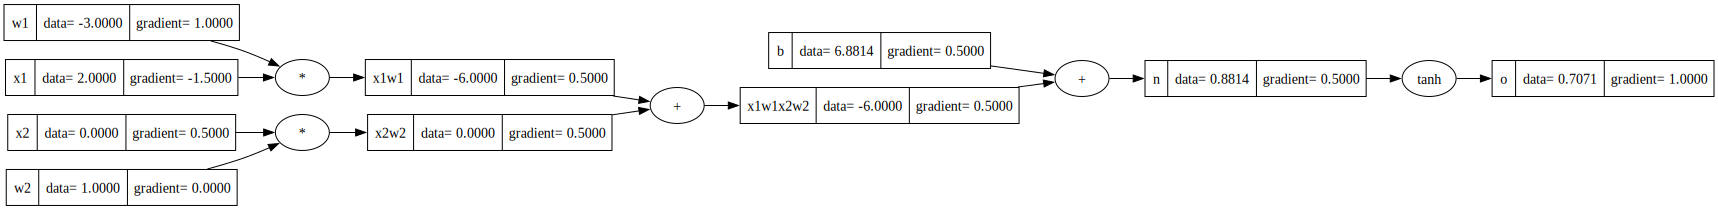

In [431]:
# now we can produce this result by defining back prop in the class
o.grad = 1.0
o.backprop()
create_graph(o)

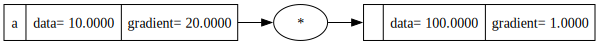

In [433]:
#bug fixes :: ie.. the node must retain its gradient state as it may be used again
# if we create a net that looks like this
a = vals(10,_label='a')
b = a * a #we get a gradient of 1 even though it should be 2 fixed through adding back derivatives in class(add mul ops)
b.backprop()
create_graph(b)

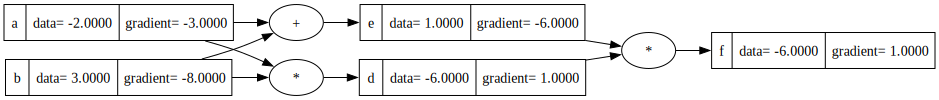

In [435]:
a = vals(-2.0, _label= 'a')
b = vals(3.0, _label= 'b')
d = a* b ; d._label = 'd'
e = a+ b ; e._label = 'e'
f = d* e ; f._label = 'f'

f.backprop()
create_graph(f)

THIS IS THE SAME OPS AS ABOVE BUT WITH THE EXPO IMPLEMENTED :

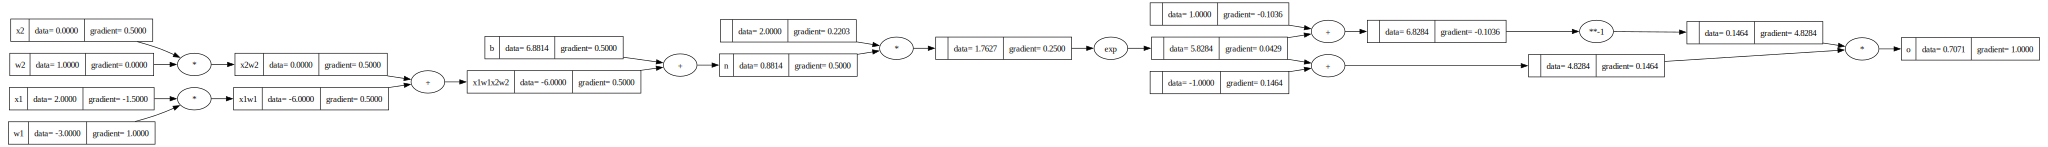

In [37]:
#now we will write a nural net by initalising weight biases and inputs from the class vals we created

#inputs x1, x2
x1 = vals(2.0, _label='x1')
x2 = vals(0.0, _label='x2')
#weights w1, w2
w1 = vals(-3.0, _label='w1')
w2 = vals(1.0, _label='w2')
#bias
b = vals(6.8813735870195432, _label='b')
#we take the dot product of the inputs agianst weights to get the vector
x1w1 = x1 * w1 ; x1w1._label = 'x1w1'
x2w2 = x2 * w2 ; x2w2._label = 'x2w2'
#this corresponds to [inputs]*[weights] ;we add these
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2._label = 'x1w1x2w2'
#we add the bias(b) to the vector
res = x1w1x2w2 + b ; res._label = 'n'
o = res.tanh() 

# here it is like tanh(x) = tanh(res)
# o = ( res.expo() - (res.__neg__()).expo()   )/(  res.expo() + (res.__neg__()).expo()     )
e  = (2*res).expo()
o = ( e - 1 )/( e + 1 )

o.backprop()
o._label = 'o'
o.grad = 1.0
create_graph(o)



NOW WE WILL CRAETE A NURAL NET WITH PYTORCH AND WATCH THE PEOJECT IN ACTION!!!!

In [49]:
import torch
import random

In [43]:
x1 = torch.tensor([2.0]).double() ; x1.requires_grad  = True
w1 = torch.tensor([-3.0]).double() ; w1.requires_grad  = True
x2 = torch.tensor([0.0]).double() ; x2.requires_grad  = True
w2 = torch.tensor([1.0]).double() ; w2.requires_grad  = True
b = torch.tensor([6.8813735870195432]).double() ; b.requires_grad  = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
o.backward()

print('_____')

print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

_____
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [80]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [vals(random.uniform(-1,1)) for _ in range(nin)]
    self.b = vals(random.uniform(-1,1))
  
  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [81]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

the data is -0.2112016238626248 

In [85]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]

In [87]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss.backprop()

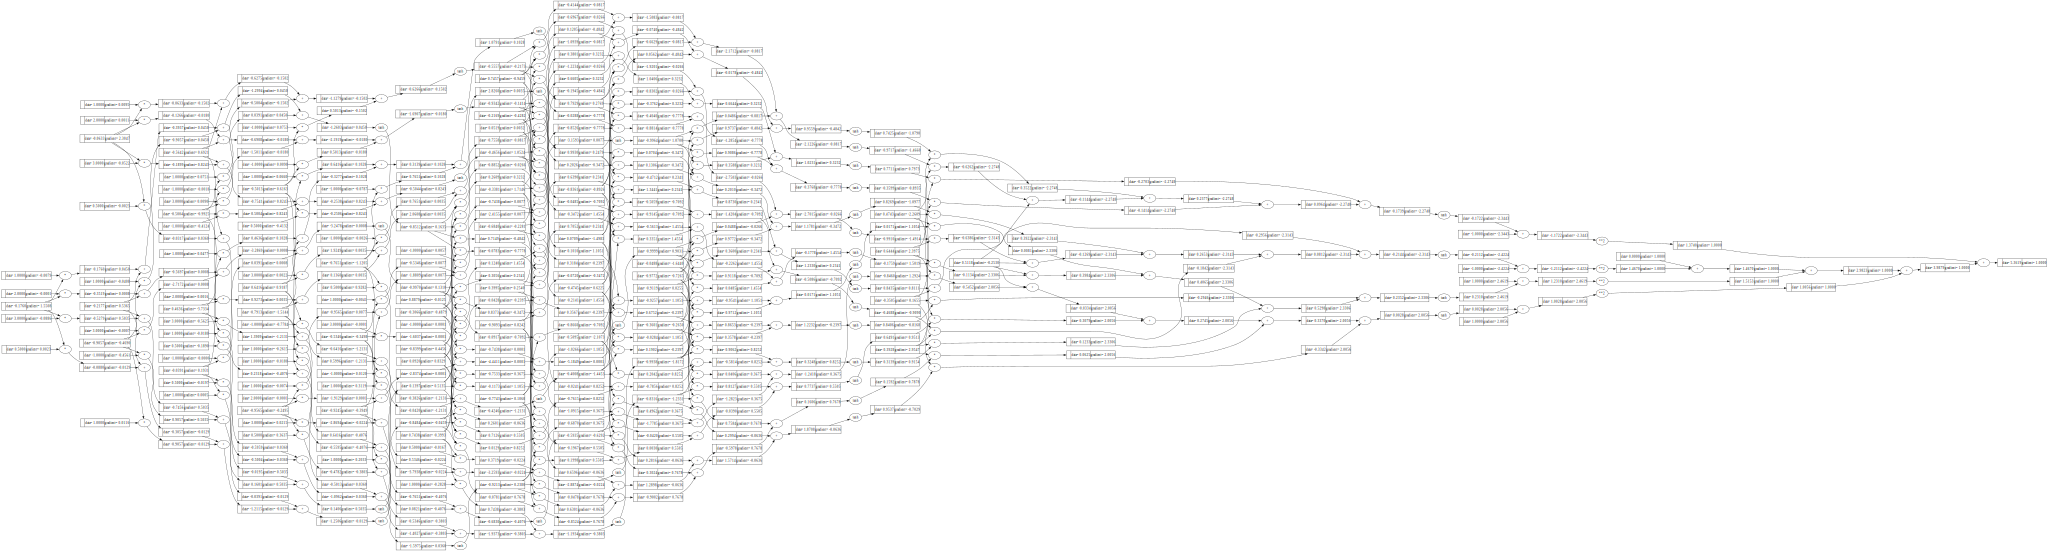

In [88]:
create_graph(loss)